In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

api = wandb.Api()
sweep_id = "2t59ndoh" # divide by sqrt(d)
sweep_id = "mo18ovc2"
sweep = api.sweep("lauro/mup_test/" + sweep_id)

In [2]:
# for run in sweep.runs:
#     nlayers = run.config['model_config']['num_layers']
#     if nlayers != 2:
#         print(run.name, run.state, run.config['model_config']['num_layers'])

# Load Wandb Data

In [3]:
wandb_data = []
for run in tqdm.tqdm(sweep.runs):
    if run.state == 'finished':
        wandb_data.append([
            run.config['d_model'],
            run.history(),
        ])

100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


In [44]:
d, his = wandb_data[0]
his['_timestamp']

0    1.691488e+09
1    1.691488e+09
2    1.691488e+09
3    1.691488e+09
4    1.691488e+09
Name: _timestamp, dtype: float64

# Helper Functions

In [13]:
def get_act_data(timestep: int, name: str):
    act_data = {}
    for r in wandb_data:
        size, his = r
        stat = his[name][timestep]

        try: 
            act_data[size].append(stat)
        except KeyError:
            act_data[size] = [stat]
    return act_data


def get_means_and_stds(act_data):
    """
    act_data is a dictionary of lists of activations for each size, eg
    {
        100: [0.1, 0.2, 0.3], 
        200: [0.4, 0.5, 0.6]
    }
    """
    sizes = list(act_data.keys())
    means = np.array([np.mean(act_data[size]) for size in sizes])
    stds = np.array([np.std(act_data[size]) / np.sqrt(np.mean(act_data[size])) for size in sizes])

    sort_idx = np.argsort(sizes)
    sizes = np.array(sizes)[sort_idx]
    means = means[sort_idx]
    stds = stds[sort_idx]
    return sizes, means, stds


def plot_single(timestep: int, name: str, ax=None, title=None):
    """plot one lineplot of activation stats x model size"""
    act_data = get_act_data(timestep, name)
    sizes, means, stds = get_means_and_stds(act_data)

    if ax is None:
        ax = plt.gca()

    ax.plot(sizes, means, "-o")
    ax.fill_between(sizes, means - stds, means + stds, alpha=0.5)
    ax.set_xlabel('Model Size')
#    ax.set_ylabel('L1 of Activations')
#    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(title)

In [14]:
#a = get_act_data(1, get_name())

# Plot

In [70]:
def get_name(prefix="train/", layer: int = 0, layertype: str = "residual_pre_attention") -> str:
    """layertype can be pre_attention or pre_mlp"""
    return f"{prefix}activation_stats/layer_{layer}__{layertype}__l1"


def plot_activations(layer: int = 0, layertype: str = "pre_attention", axs=None):
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(20, 4))
    target = get_name(prefix="", layer=layer, layertype=layertype)
    plot_single(0, "val/" + target, ax=axs[0], title=f"Timestep 0 (Validation)")
    for i, t in zip([1, 2], [3, 4]):
        plot_single(t, "train/" + target, ax=axs[i], title=f"Timestep {t}")
        axs[i].set_yticklabels([])

In [71]:
# print columns
print(*[col for col in wandb_data[0][1].columns if "train/" in col and "l1" in col], sep='\n')

train/activation_stats/layer_0__residual_pre_mlp__l1
train/activation_stats/layer_0__mlp_mid__l1
train/activation_stats/layer_0__mlp_out__l1
train/activation_stats/layer_1__mlp_out__l1
train/activation_stats/layer_1__residual_pre_mlp__l1
train/activation_stats/layer_1__residual_pre_attention__l1
train/activation_stats/layer_0__attention_out__l1
train/activation_stats/layer_0__residual_pre_attention__l1
train/activation_stats/layer_1__attention_out__l1
train/activation_stats/layer_1__mlp_mid__l1


## Residual Activations

In [72]:
FIGSIZE = (20, 6)

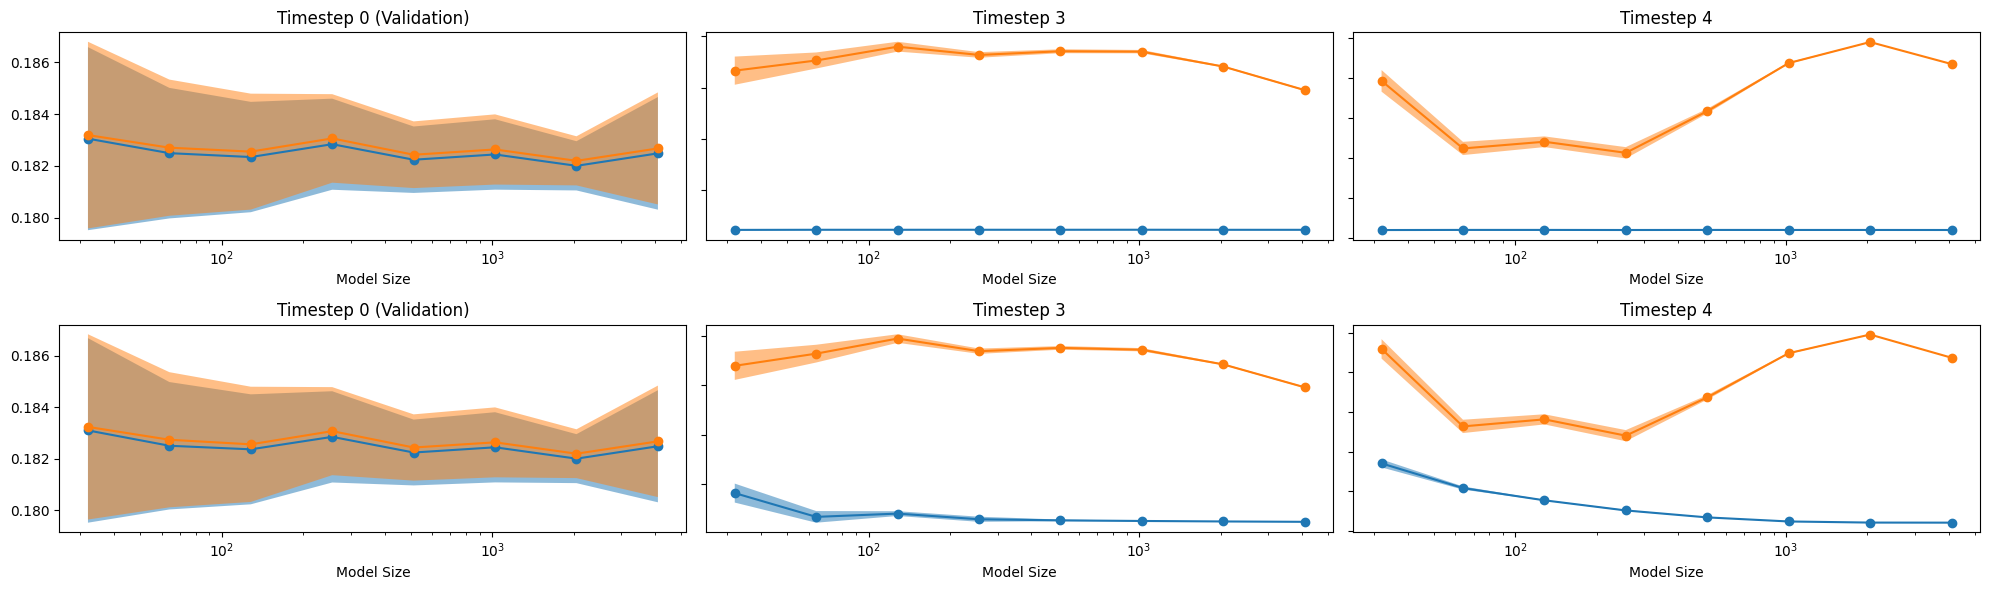

In [73]:
_, axs = plt.subplots(2, 3, figsize=FIGSIZE)
plot_activations(layer=0, layertype="residual_pre_attention", axs=axs[0])
plot_activations(layer=1, layertype="residual_pre_attention", axs=axs[0])

plot_activations(layer=0, layertype="residual_pre_mlp", axs=axs[1])
plot_activations(layer=1, layertype="residual_pre_mlp", axs=axs[1])

plt.tight_layout()

## Attention

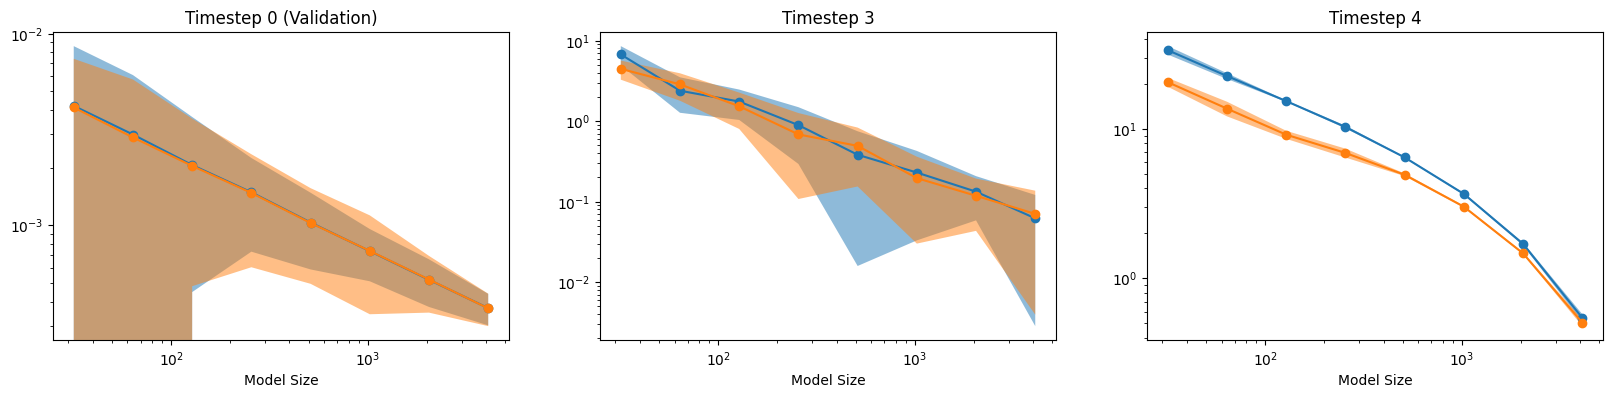

In [83]:
_, axs = plt.subplots(1, 3, figsize=(20, 4))
plot_activations(layer=0, layertype="attention_out", axs=axs)
plot_activations(layer=1, layertype="attention_out", axs=axs)

for ax in axs:
    ax.set_yscale("log")

## MLP Activations

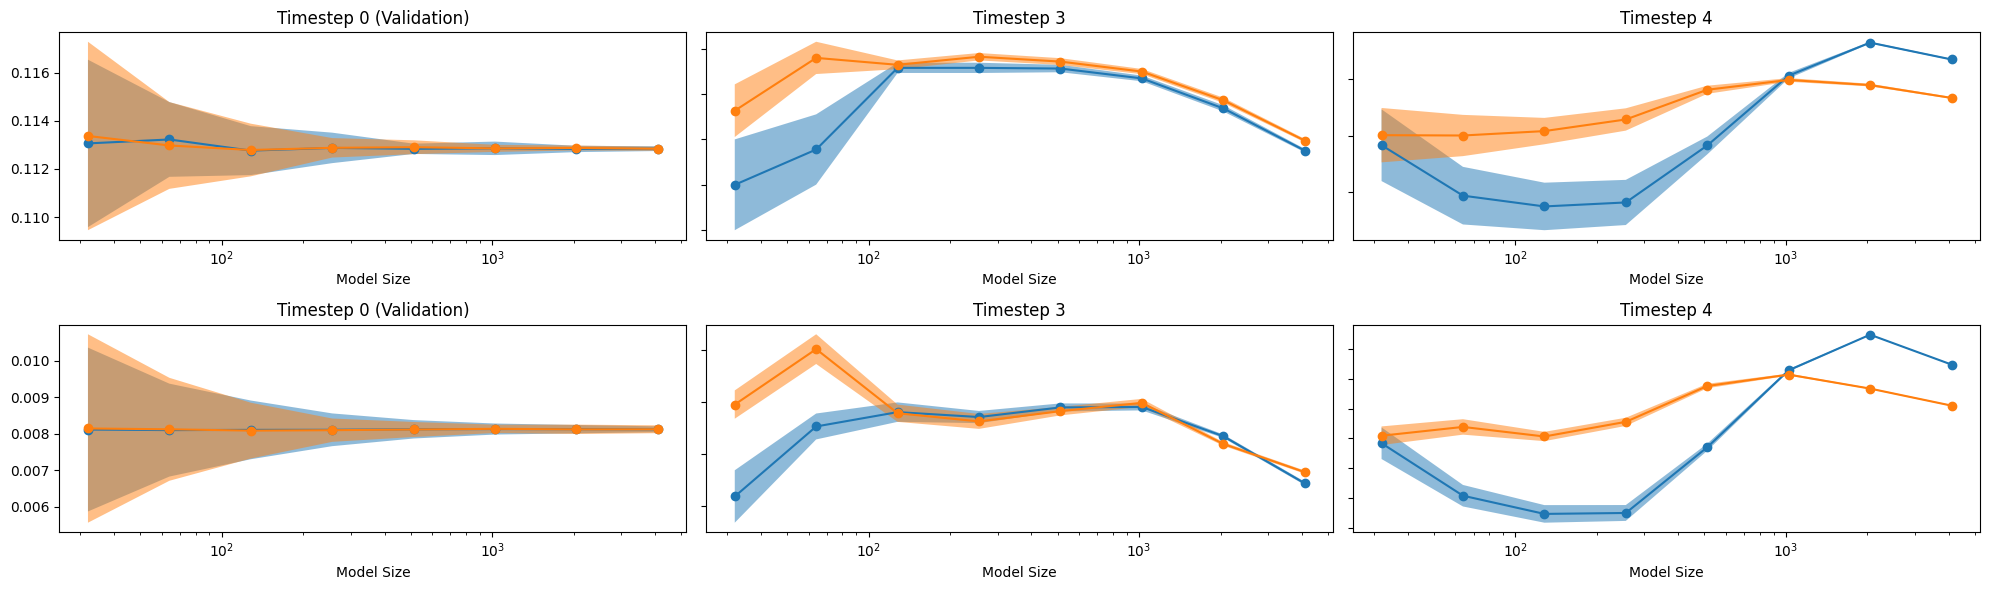

In [82]:
_, axs = plt.subplots(2, 3, figsize=FIGSIZE)
plot_activations(layer=0, layertype="mlp_mid", axs=axs[0])
plot_activations(layer=1, layertype="mlp_mid", axs=axs[0])

plot_activations(layer=0, layertype="mlp_out", axs=axs[1])
plot_activations(layer=1, layertype="mlp_out", axs=axs[1])

plt.tight_layout()

# Output

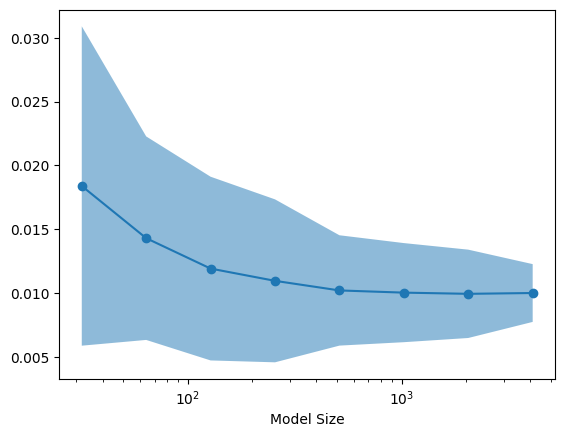

In [81]:
# only makes sense to plot for timestep 2 (bc otherwise zero)
plot_single(2, "train/activation_stats/output")
plt.yscale("linear")